In [225]:
import numpy as np                                                                                                                              
import pandas as pd                                                                                                                             
import matplotlib                                                                                                                               
from matplotlib import pyplot as plt                                                                                                            
                                                                                                                                                
import re                                                                                                                                       
import os                                                                                                                                       
import datetime
import sys  
sys.path.insert(0, '/home/anup/goofy/codes/ephys_analysis')
from plotting_functions import format_plot,colors_hex                                                                                           
                                                                                                                                                
def compute_ppf(df):                                                                                                                            
    # compute paired-pulse facilitation                                                                                                         
    # get all the factors                                                                                                                       
    # ----------------                                                                                                                          
    expdate = df.index.unique(level="expdate").strftime("%Y%m%d").values                                                                        
    region = df.index.unique(level="region").values                                                                                             
    area = df.index.unique(level="area").values                                                                                                 
    compartment = df.index.unique(level="compartment").values                                                                                   
    neuronid = df.index.unique(level="neuronid").values                                                                                         
    dendriteid = df.index.unique(level="dendriteid").values                                                                                     
    spineid = df.index.unique(level="spineid").values                                                                                           
    blocker = df.index.unique(level="blocker").values                                                                                           
    isi = df.index.unique(level="isi").values                                                                                                   
    isweep = df.index.unique(level="isweep").values                                                                                             
    # ------------------------                                                                                                                  
    # sweeps = df.index.unique(level="isweep").values                                                                                           
    # stims = df.index.unique(level="istim").values                                                                                             
    #facilitation = stim2/stim1: stim0 = noise                                                                                                  
    # peak1 = df.xs([1],level=["istim"])[["peak"]].values[0][0]                                                                                 
    # peak2 = df.xs([2],level=["istim"])[["peak"]].values[0][0]                                                                                 
    peak1 = df[df["istim"]==1]["peak"].values[0]                                                                                                
    peak2 = df[df["istim"]==2]["peak"].values[0]                                                                                                
    ppf = peak2/peak1    
    # ----------                                                                                                                                
    outdf = pd.DataFrame({                                                                                                                      
        "expdate":expdate,                                                                                                                      
        "region":region,                                                                                                                        
        "area":area,                                                                                                                            
        "compartment":compartment,                                                                                                              
        "neuronid":neuronid,                                                                                                                    
        "dendriteid":dendriteid,                                                                                                                
        "spineid":spineid,                                                                                                                      
        "blocker":blocker,                                                                                                                      
        "isi":isi,                                                                                                                              
        "isweep":isweep,                                                                                                                        
        "ppf":ppf})                                                                                                                             
    # # -----------                                                                                                                             
    outdf = outdf.reset_index()                                                                                                                 
    # create multiindex                                                                                                                         
    outdf = outdf.set_index(["expdate","region","area","compartment","neuronid","dendriteid","spineid","blocker","isi","isweep"]).sort_index()  
    # # select columns to include in the outdf                                                                                                  
    outdf = outdf[["ppf"]]                                                                                                                      
    # # print(expdate,region,isi,sweeps,stims)                                                                                                  
    return(outdf)                                                                                                                               
# }     

In [271]:
# analysis of single spine uncaging glutamate CA1 & PFC-L5 for AMPAR-Desen                                                                      
dfpath = "/home/anup/goofy/data/beiquelab/glu_uncage_spine_single_epsc"                                                                         
dfname = "ephys_analysis_epscs_deconvolve_template_match_ampar_desen.csv"                                                                       
                                                                                                                                                
# load data                                                                                                                                     
with open(os.path.join(dfpath,dfname),'r') as csvfile:                                                                                          
    df = pd.read_csv(csvfile)                                                                                                                   
                                                                                                                                                
# preprocessing                                                                                                                                 
# change column data types                                                                                                                      
df["expdate"] = pd.to_datetime(df["expdate"],format="%Y%m%d")                                                                                   
df["dob"] = pd.to_datetime(df["dob"],format="%Y%m%d")                                                                                           
df["age"] = (df["expdate"]-df["dob"]).dt.days                                                                                                   
df["spineid"] = df["spineid"].astype("int8")                                                                                                    
df["neuronid"] = df["neuronid"].astype("int8")                                                                                                  
df["dendriteid"] = df["dendriteid"].astype("int8")                                                                                              
df["isweep"] = df["isweep"].astype("int16")                                                                                                     
df["istim"] = df["istim"].astype("int8")                                                                                                        
df["nsweeps"] = df["nsweeps"].astype("int16")                                                                                                   
df["nstims"] = df["nstims"].astype("int16")                                                                                                     
df["isi"] = (df["isi"]*1000).astype(int)                                                                                                        
# df.set_index(["expdate","ephysfile","neuronid","dendriteid","spineid","isweep","istim"],inplace=True)                                         
# print(df)                                                                                                                                       
# print(df.columns)                                                                                                                               
# print(df["age"].unique())                                                                                                                       
# print(df["blocker"].unique())                                                                                                                   
# print(df["region"].unique())                                                                                                                    
# print(df["area"].unique())                                                                                                                      
# print(df["compartment"].unique())                                                                                                               
# print(df["expdate"].unique())                                                                                                                   
# print(df["cellfolder"].unique())                                                                                                                
# print(df["neuronid"].unique())                                                                                                                  
# print(df["dendriteid"].unique()) 
# print(df["spineid"].unique())                                                                                                                   
# print(np.sort(df["isi"].unique()))                                                                                                              
# print(df["isweep"].unique())                                                                                                                    
# print(df["istim"].unique())                                                                                                                     
# ------------------------------                                                                                                                
# filter out the bad files                                                                                                                      
bad_ephysfiles = ["20d02040","20d02042","20d02049","20d02066","20d08075","20d09080","20d09120","20d09136","20d09145","20d16107","20d18167"]     
bad_ephysfiles = ["".join((bad_ephysfile,".abf")) for bad_ephysfile in bad_ephysfiles]                                                          
# df = df[~df.ephysfile.isin(bad_ephysfiles)]                                                                                                   
# ----------------                                                                                                                              
df.set_index(["expdate","region","area","compartment","neuronid","dendriteid","spineid","blocker","isi","isweep"],inplace=True)                 
# print(df.columns)                                                                                                                               
grouped = df.groupby(level=["expdate","region","area","compartment","neuronid","dendriteid","spineid","blocker","isi","isweep"],as_index=False) 
# print(grouped.level)                                                                                                                            
ppfdf = grouped.apply(compute_ppf)                                                                                                              
# print(ppfdf)                                                                                                                                    
grouped = ppfdf.groupby(level=["expdate","region","area","compartment","neuronid","dendriteid","spineid","blocker","isi"])                      
avgdf = grouped.mean()       # averaged across sweep                                                                                            
avgdf.reset_index(inplace=True)                                                                                                                 
spines = avgdf[["expdate","region","area","compartment","neuronid","dendriteid","spineid","blocker"]].astype("str").agg("_".join,axis=1)        
avgdf[["spine"]] = spines                                                                                                                       
avgdf.set_index(["expdate","region","area","compartment","neuronid","dendriteid","spineid","blocker","isi"],inplace=True)                       
print(avgdf)                 

                                                                                ppf  \
expdate  region area compartment neuronid dendriteid spineid blocker isi              
20201201 hc     ca1  apical      1        1          1       ctrl    10    1.551357   
                                                                     30    2.372340   
                                                                     40    1.161273   
                                                                     50    1.301095   
                                                                     100   1.016177   
...                                                                             ...   
20201218 hc     ca1  basal       1        1          5       ctz     200   0.925545   
                                                                     400   1.377456   
                                                                     600   1.109670   
                                           

ctrlspines:  ['20201202_pfc_l5_apical_1_1_1', '20201202_pfc_l5_apical_1_1_2', '20201202_pfc_l5_apical_1_1_3', '20201202_pfc_l5_apical_2_1_1', '20201208_pfc_l5_apical_1_1_1', '20201208_pfc_l5_apical_1_1_2', '20201209_pfc_l5_apical_1_2_1', '20201209_pfc_l5_apical_1_2_2', '20201209_pfc_l5_apical_1_2_3', '20201209_pfc_l5_apical_1_2_4']
ctzspines:  ['20201209_pfc_l5_apical_1_1_1', '20201209_pfc_l5_apical_1_1_2', '20201209_pfc_l5_apical_1_2_2', '20201209_pfc_l5_apical_1_2_3']
ctrlctzspines:  ['20201209_pfc_l5_apical_1_2_3', '20201209_pfc_l5_apical_1_2_2']
[  10   20   30   40   50  100  200  400  600  800 1000] [0.83980019 0.68191814 0.66900466 0.87519399 0.7409515  0.62755864
 0.69907921 0.55482253 0.82032424 0.66158884 0.89876432]
[  10   20   30   40   50  100  200  400  600  800 1000] [1.01695736 1.99991072 1.34618447 1.7359934  1.45828111 1.51187309
 2.05674228 0.7282609  0.92805888 0.81311899 0.77868367]


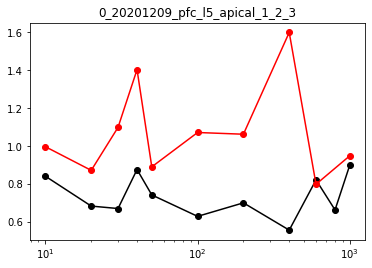

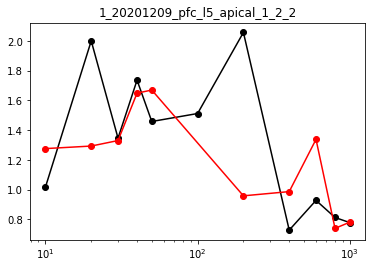

In [357]:
# plot spines that are also treated with CTZ
# selectdf = avgdf.xs(["hc","ca1","apical"],level=["region","area","compartment"],drop_level=False)                                               
#selectdf = avgdf.xs(["hc","ca1","basal"],level=["region","area","compartment"],drop_level=False)                                           
selectdf = avgdf.xs(["pfc","l5","apical"],level=["region","area","compartment"],drop_level=False)                                          
# selectdf = avgppfdf.xs(["pfc","l5","basal"],level=["region","area","compartment"],drop_level=False)   
# ----------------------------------------------
ctrlspines = selectdf["spine"][selectdf["spine"].str.contains('ctrl')].unique()                                                                 
ctrlspines = [re.findall(r'.*[^_ctrl]',spine)[0] for spine in ctrlspines]                                                                       
ctzspines = selectdf["spine"][selectdf["spine"].str.contains('ctz')].unique()                                                                   
ctzspines = [re.findall(r'.*[^_ctz]',spine)[0] for spine in ctzspines]                                                                          
ctrlctzspines = list(set(ctrlspines).intersection(set(ctzspines)))
print("ctrlspines: ",ctrlspines)
print("ctzspines: ",ctzspines)
print("ctrlctzspines: ",ctrlctzspines)
for i,spine in zip(range(len(ctrlctzspines)),ctrlctzspines):                                      
    fh = plt.figure()
    ah = fh.add_subplot(111)
    ctrlspine = selectdf[selectdf["spine"] == "".join((spine,'_ctrl'))] 
    ctzspine = selectdf[selectdf["spine"] == "".join((spine,'_ctz'))] 
#     print(ctrlspine)
#     print(ctzspine)
    ctrlxvals = ctrlspine.reset_index()["isi"].to_numpy()
    ctrlyvals = ctrlspine["ppf"].to_numpy()
    ctzxvals = ctzspine.reset_index()["isi"].to_numpy()
    ctzyvals = ctzspine["ppf"].to_numpy()
    print(ctrlxvals,ctrlyvals)
    ah.semilogx(ctrlxvals,ctrlyvals,color='k',marker='o')
    ah.semilogx(ctzxvals,ctzyvals,color='r',marker='o')
    ah.set_title("".join((str(i),"_",spine)))
#   }
plt.show()
plt.close()

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True] [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
                                                                      isi  \
expdate  region area compartment neuronid dendriteid spineid blocker        
20201208 pfc    l5   basal       1        2          1       ctrl      10   
                                                             ctrl      20   
                                                             ctrl      30   
                                                             ctrl      40   
    

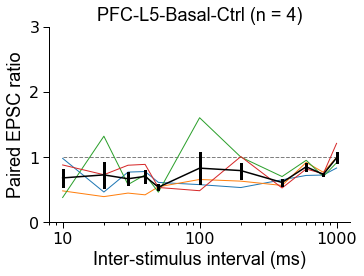

In [370]:
# plot individual data along with averaged values - Ctrl
# select experimental groups
ctrldf = avgdf.xs(key=["pfc","l5","basal","ctrl"],level=["region","area","compartment","blocker"],drop_level=False)
# filter spines - apply masks
# rm_ctrlspines = ["20201201_hc_ca1_apical_1_1_1_ctrl"] # CA1-Apical-Ctrl 
# rm_ctrlspines = ["20201218_hc_ca1_basal_1_1_4_ctrl"] # CA1-Basal-Ctrl
# rm_ctrlspines = ["20201216_hc_ca1_basal_3_1_1_ctz"] # CA1-Basal-Ctz
# rm_ctrlspines = [] # PFC-L5-Apical-Ctrl
rm_ctrlspines = [] # PFC-L5-Basal-Ctrl
isis = np.array([10,20,30,40,50,100,200,400,600,800,1000])
mask1 = list(~ctrldf["spine"].isin(rm_ctrlspines))
mask2 = ctrldf.index.get_level_values("isi").isin(isis)
print(mask1,mask2)
ctrldf = ctrldf[mask1 & mask2].reset_index(level="isi",drop=False)
print(ctrldf.head())
ctrlspines = ctrldf["spine"].unique()
print()
# ---------------
print(len(ctrlspines))
print(len(ctzspines))
fh = plt.figure()
ah = fh.add_subplot(111)
for spine in ctrlspines:
    print(spine)
    xvals = ctrldf.loc[ctrldf["spine"]==spine,"isi"].to_numpy()
    yvals = ctrldf.loc[ctrldf["spine"]==spine,"ppf"].to_numpy()
    ah.semilogx(xvals,yvals,marker="",linestyle='-',linewidth=1,label=spine)
    # }
# --------------------
avgsemfun = lambda x:pd.DataFrame({"avg":np.mean(x),"sem":np.std(x)/np.sqrt(len(x)),"count":len(x)})
avgsemdf = ctrldf.groupby(["isi"])[["ppf"]].apply(avgsemfun)
print(avgsemdf)
for i in range(len(avgsemdf)):
    xval = avgsemdf.index.get_level_values("isi")[i]
    avgval = avgsemdf.xs(key=xval,level="isi")["avg"].to_numpy()[0]
    semval = avgsemdf.xs(key=xval,level="isi")["sem"].to_numpy()[0]
    ah.plot([xval,xval],[avgval-semval,avgval+semval],linewidth=3,color="k")
ah.hlines(1,min(isis),max(isis),linestyle="--",color='grey',linewidth=1)
ah.plot(list(avgsemdf.index.get_level_values(level="isi")),list(avgsemdf["avg"]),linestyle="-",marker="None",color='k')
# plt.legend()
# -------------------------------------
xlabel = "Inter-stimulus interval (ms)"
ylabel = "Paired EPSC ratio"
title = "".join(("PFC-L5-Basal-Ctrl"," (n = ",str(len(ctrlspines)),")"))
ah.set_xticks([10,100,1000])                                                                                                                    
ah.set_xticklabels([10,100,1000],fontsize=16)                                                                                                   
ah.set_ylim([0.4,2.6])                                                                                                                          
ah.set_yticks([0,1,2,3])                                                                                                                
ah.set_yticklabels([0,1,2,3],fontsize=16)           
fh,ah = format_plot(fh,ah,xlabel,ylabel,title)
# ---------------------------------
figname = "pfc_l5_basal_epsc_ppr_single_spine_amapar_desen_ctrl.png"                                                                                
fh.savefig(os.path.join(dfpath,figname),facecolor="w",dpi=300)

['20201208_pfc_l5_basal_1_2_2_ctz' '20201208_pfc_l5_basal_1_2_3_ctz']
4
2
20201208_pfc_l5_basal_1_2_1_ctrl
20201208_pfc_l5_basal_1_2_2_ctrl
20201208_pfc_l5_basal_1_2_3_ctrl
20201209_pfc_l5_basal_1_1_1_ctrl
20201208_pfc_l5_basal_1_2_2_ctz
20201208_pfc_l5_basal_1_2_3_ctz


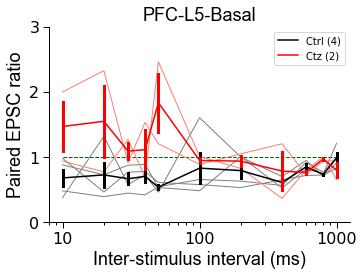

In [369]:
# plot individual data along with averaged values - Ctrl and Ctz
# select experimental groups
ctrldf = avgdf.xs(key=["pfc","l5","basal","ctrl"],level=["region","area","compartment","blocker"],drop_level=False)
ctzdf = avgdf.xs(key=["pfc","l5","basal","ctz"],level=["region","area","compartment","blocker"],drop_level=False)
# filter spines - apply masks
# rm_ctrlspines = ["20201201_hc_ca1_apical_1_1_1_ctrl"] # CA1 apical
# rm_ctrlspines = [] # PFC-L5_Apical-ctrl
rm_ctzspines = [] # PFC-L5-basal-Ctz
isis = np.array([10,20,30,40,50,100,200,400,600,800,1000])
mask1 = list(~ctrldf["spine"].isin(rm_ctrlspines))
mask2 = ctrldf.index.get_level_values("isi").isin(isis)
ctrldf = ctrldf[mask1 & mask2].reset_index(level="isi",drop=False)
ctrlspines = ctrldf["spine"].unique()
# ctrlspines2 = [re.findall(r'.*[^_ctrl]',spine)[0] for spine in ctrlspines]   
# --------------
# rm_ctzspines = ["20201218_hc_ca1_apical_1_2_1_ctz","20201218_hc_ca1_apical_1_2_2_ctz"] # CA1 Apical
# rm_ctzspines = ["20201216_hc_ca1_basal_3_1_1_ctz"] # CA1-Basal-Ctz
# rm_ctzspines = [] # PFC-L5-Apical-Ctz
rm_ctzspines = [] # PFC-L5-basal-Ctz
isis = np.array([10,20,30,40,50,100,200,400,600,800,1000])
mask1 = list(~ctzdf["spine"].isin(rm_ctzspines))
mask2 = ctzdf.index.get_level_values("isi").isin(isis)
ctzdf = ctzdf[mask1 & mask2].reset_index(level="isi",drop=False)
ctzspines = ctzdf["spine"].unique()
# ctzspines2 = [re.findall(r'.*[^_ctz]',spine)[0] for spine in ctzspines]   
# ctrlctzspines = list(set(ctrlspines2).intersection(set(ctzspines2)))
print(ctzspines)
# ---------------
print(len(ctrlspines))
print(len(ctzspines))
#print(ctrldf.head())
# ----------------
fh = plt.figure()
ah = fh.add_subplot(111)
for spine in ctrlspines:
    print(spine)
    xvals = ctrldf.loc[ctrldf["spine"]==spine,"isi"].to_numpy()
    yvals = ctrldf.loc[ctrldf["spine"]==spine,"ppf"].to_numpy()
    ah.semilogx(xvals,yvals,marker="",linestyle='-',linewidth=1,color="grey")
    # }
# --------------------
for spine in ctzspines:
    print(spine)
    xvals = ctzdf.loc[ctzdf["spine"]==spine,"isi"].to_numpy()
    yvals = ctzdf.loc[ctzdf["spine"]==spine,"ppf"].to_numpy()
    ah.semilogx(xvals,yvals,marker="",linestyle='-',linewidth=1,color="salmon")
    # }
# -------------------
#plt.legend()
avgsemfun = lambda x:pd.DataFrame({"avg":np.mean(x),"sem":np.std(x)/np.sqrt(len(x)),"count":len(x)})
avgsemctrldf = ctrldf.groupby(["isi"])[["ppf"]].apply(avgsemfun)
avgsemctzdf = ctzdf.groupby(["isi"])[["ppf"]].apply(avgsemfun)
ctrllabel = "".join(("Ctrl (",str(len(ctrlspines)),")"))
ctzlabel = "".join(("Ctz (",str(len(ctzspines)),")"))
# --------------------
for i in range(len(avgsemctrldf)):
    xvalctrl = avgsemctrldf.index.get_level_values("isi")[i]
    avgvalctrl = avgsemctrldf.xs(key=xvalctrl,level="isi")["avg"].to_numpy()[0]
    semvalctrl = avgsemctrldf.xs(key=xvalctrl,level="isi")["sem"].to_numpy()[0]
    ah.plot([xvalctrl,xvalctrl],[avgvalctrl-semvalctrl,avgvalctrl+semvalctrl],linewidth=3,color="k")
ah.plot(list(avgsemctrldf.index.get_level_values(level="isi")),list(avgsemctrldf["avg"]),linestyle="-",marker="None",color='k',label=ctrllabel)
# -----------------
for i in range(len(avgsemctzdf)):
    xvalctz = avgsemctzdf.index.get_level_values("isi")[i]
    avgvalctz = avgsemctzdf.xs(key=xvalctz,level="isi")["avg"].to_numpy()[0]
    semvalctz = avgsemctzdf.xs(key=xvalctz,level="isi")["sem"].to_numpy()[0]
    ah.plot([xvalctz,xvalctz],[avgvalctz-semvalctz,avgvalctz+semvalctz],linewidth=3,color="red")
ah.plot(list(avgsemctzdf.index.get_level_values(level="isi")),list(avgsemctzdf["avg"]),linestyle="-",marker="None",color='red',label=ctzlabel)
# -------------------
ah.hlines(1,min(isis),max(isis),linestyle="--",color='darkgreen',linewidth=1)
# ---------------------------------
xlabel = "Inter-stimulus interval (ms)"
ylabel = "Paired EPSC ratio"
title = "".join(("PFC-L5-Basal"))
ah.set_xticks([10,100,1000])                                                                                                                    
ah.set_xticklabels([10,100,1000],fontsize=16)                                                                                                   
ah.set_ylim([0.4,2.6])                                                                                                                          
ah.set_yticks([0,1,2,3])                                                                                                                
ah.set_yticklabels([0,1,2,3],fontsize=16)           
fh,ah = format_plot(fh,ah,xlabel,ylabel,title)
plt.legend()
# ------------------------------------
figname = "pfc_l5_basal_epsc_ppr_single_spine_amapar_desen_ctrl_ctz.png"                                                                                
fh.savefig(os.path.join(dfpath,figname),facecolor="w",dpi=300)